In [1]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class DeepQNetwork(nn.Module):
    def __init__(self, ALPHA):
        super(DeepQNetwork, self).__init__()
        #self.conv1 = nn.Conv2d(3, 32, 8, stride=4, padding=1)
        self.conv1 = nn.Conv2d(1, 32, 8, stride=4, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 128, 3)
        #self.fc1 = nn.Linear(128*23*16, 512)
        self.fc1 = nn.Linear(128*19*8, 512)
        self.fc2 = nn.Linear(512, 6)
        self.optimizer = optim.SGD(self.parameters(), lr=ALPHA, momentum=0.9)
        #self.optimizer = optim.RMSprop(self.parameters(), lr=ALPHA)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')     
        print('Using device:', self.device)
        print()
        self.to(self.device)

    def forward(self, observation):
        observation = T.Tensor(observation).to(self.device)        
        #observation = observation.view(-1, 3, 210, 160).to(self.device)        
        observation = observation.view(-1, 1, 185, 95)      
        observation = F.relu(self.conv1(observation))     
        observation = F.relu(self.conv2(observation))       
        observation = F.relu(self.conv3(observation))  
        #observation = observation.view(-1, 128*23*16).to(self.device)        
        observation = observation.view(-1, 128*19*8)    
        observation = F.relu(self.fc1(observation))  
        actions = self.fc2(observation)
        return actions

class Agent(object):
    def __init__(self, gamma, epsilon, alpha, 
                 maxMemorySize, epsEnd=0.05, 
                 replace=10000, actionSpace=[0,1,2,3,4,5]):
        self.GAMMA = gamma
        self.EPSILON = epsilon
        self.EPS_END = epsEnd
        self.ALPHA = alpha
        self.actionSpace = actionSpace
        self.memSize = maxMemorySize
        self.steps = 0
        self.learn_step_counter = 0
        self.memory = []
        self.memCntr = 0
        self.replace_target_cnt = replace
        self.Q_eval = DeepQNetwork(alpha)
        self.Q_next = DeepQNetwork(alpha)

    def storeTransition(self, state, action, reward, state_):
        if self.memCntr < self.memSize:
            self.memory.append([state, action, reward, state_])
        else:            
            self.memory[self.memCntr%self.memSize] = [state, action, reward, state_]
        self.memCntr += 1
        
    def chooseAction(self, observation):
        rand = np.random.random()
        actions = self.Q_eval.forward(observation)
        if rand < 1 - self.EPSILON:
            action = T.argmax(actions[1]).item()
        else:
            action = np.random.choice(self.actionSpace)            
        self.steps += 1
        return action
    
    def learn(self, batch_size):
        self.Q_eval.optimizer.zero_grad()
        if self.replace_target_cnt is not None and \
           self.learn_step_counter % self.replace_target_cnt == 0:
            self.Q_next.load_state_dict(self.Q_eval.state_dict())

        if self.memCntr+batch_size < self.memSize:            
            memStart = int(np.random.choice(range(self.memCntr)))
        else:
            memStart = int(np.random.choice(range(self.memSize-batch_size-1)))
        miniBatch=self.memory[memStart:memStart+batch_size]
        memory = np.array(miniBatch)

        # convert to list because memory is an array of numpy objects
        Qpred = self.Q_eval.forward(list(memory[:,0][:])).to(self.Q_eval.device)
        Qnext = self.Q_next.forward(list(memory[:,3][:])).to(self.Q_eval.device)       
        
        maxA = T.argmax(Qnext, dim=1).to(self.Q_eval.device) 
        rewards = T.Tensor(list(memory[:,2])).to(self.Q_eval.device)        
        Qtarget = Qpred        
        Qtarget[:,maxA] = rewards + self.GAMMA*T.max(Qnext[1])
        
        if self.steps > 500:
            if self.EPSILON - 1e-4 > self.EPS_END:
                self.EPSILON -= 1e-4
            else:
                self.EPSILON = self.EPS_END

        #Qpred.requires_grad_()        
        loss = self.Q_eval.loss(Qtarget, Qpred).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()
        self.learn_step_counter += 1

In [2]:
import matplotlib.pyplot as plt 
import numpy as np

def plotLearning(x, scores, epsilons, filename):   
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Game", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-5):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    #ax2.xaxis.tick_top()
    ax2.axes.get_xaxis().set_visible(False)    
    ax2.yaxis.tick_right()
    #ax2.set_xlabel('x label 2', color="C1") 
    ax2.set_ylabel('Score', color="C1")       
    #ax2.xaxis.set_label_position('top') 
    ax2.yaxis.set_label_position('right') 
    #ax2.tick_params(axis='x', colors="C1")
    ax2.tick_params(axis='y', colors="C1")

    plt.savefig(filename)

Using device: cpu

Using device: cpu

done initializing memory
starting game  1 epsilon: 1.0000
score: 30.0
starting game  2 epsilon: 1.0000
score: 75.0
starting game  3 epsilon: 1.0000
score: 105.0
starting game  4 epsilon: 0.9852
score: 145.0
starting game  5 epsilon: 0.8918
score: 90.0
starting game  6 epsilon: 0.8335
score: 165.0
starting game  7 epsilon: 0.7529
score: 50.0
starting game  8 epsilon: 0.7121
score: 190.0
starting game  9 epsilon: 0.6112
score: 55.0
starting game  10 epsilon: 0.5710
score: 5.0
starting game  11 epsilon: 0.5177
score: 30.0
starting game  12 epsilon: 0.4770
score: 405.0
starting game  13 epsilon: 0.3421
score: 95.0
starting game  14 epsilon: 0.2357
score: 35.0
starting game  15 epsilon: 0.1929
score: 70.0
starting game  16 epsilon: 0.1018
score: 5.0
starting game  17 epsilon: 0.0500
score: 10.0
starting game  18 epsilon: 0.0500
score: 30.0
starting game  19 epsilon: 0.0500
score: 20.0
starting game  20 epsilon: 0.0500
score: 10.0
starting game  21 epsil

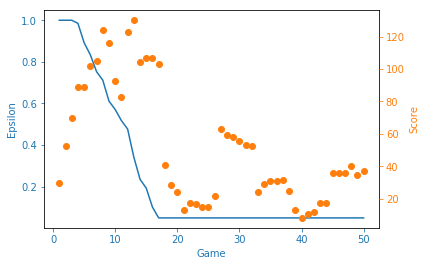

In [3]:
import gym
import numpy as np 
from gym import wrappers

if __name__ == '__main__':
    env = gym.make('SpaceInvaders-v0')
    brain = Agent(gamma=0.95, epsilon=1.0, 
                  alpha=0.003, maxMemorySize=5000,
                  replace=None)   
    while brain.memCntr < brain.memSize:
        observation = env.reset()
        done = False
        while not done:
            # 0 no action, 1 fire, 2 move right, 3 move left, 4 move right fire, 5 move left fire
            action = env.action_space.sample()
            observation_, reward, done, info = env.step(action)
            if done and info['ale.lives'] == 0:
                reward = -100                  
            brain.storeTransition(np.mean(observation[15:200,30:125], axis=2), action, reward, 
                                np.mean(observation_[15:200,30:125], axis=2))
            observation = observation_
    print('done initializing memory')

    scores = []
    epsHistory = []
    numGames = 50
    batch_size=8
    # uncomment the line below to record every episode. 
    # env = wrappers.Monitor(env, "tmp/space-invaders-1", video_callable=lambda episode_id: True, force=True)
    for i in range(numGames):
        print('starting game ', i+1, 'epsilon: %.4f' % brain.EPSILON)
        epsHistory.append(brain.EPSILON)        
        done = False
        observation = env.reset()
        frames = [np.sum(observation[15:200,30:125], axis=2)]
        score = 0
        lastAction = 0   
        while not done:
            if len(frames) == 3:
                action = brain.chooseAction(frames)
                frames = []
            else:
                action = lastAction
            observation_, reward, done, info = env.step(action)
            score += reward
            frames.append(np.sum(observation_[15:200,30:125], axis=2))
            if done and info['ale.lives'] == 0:
                reward = -100 
            brain.storeTransition(np.mean(observation[15:200,30:125], axis=2), action, reward, 
                                  np.mean(observation_[15:200,30:125], axis=2))
            observation = observation_            
            brain.learn(batch_size)
            lastAction = action
            #env.render()
        scores.append(score)
        print('score:',score)
    x = [i+1 for i in range(numGames)]
    fileName = str(numGames) + 'Games' + 'Gamma' + str(brain.GAMMA) + \
               'Alpha' + str(brain.ALPHA) + 'Memory' + str(brain.memSize)+ '.png'    
    plotLearning(x, scores, epsHistory, fileName)

In [15]:
for i in range(1):
    print('starting game ', i+1, 'epsilon: %.4f' % brain.EPSILON)
#     epsHistory.append(brain.EPSILON)        
    done = False
    observation = env.reset()
    frames = [np.sum(observation[15:200,30:125], axis=2)]
    score = 0
    lastAction = 0   
    while not done:
        if len(frames) == 3:
            action = brain.chooseAction(frames)
            frames = []
        else:
            action = lastAction
        observation_, reward, done, info = env.step(action)
        score += reward
        frames.append(np.sum(observation_[15:200,30:125], axis=2))
        if done and info['ale.lives'] == 0:
            reward = -100 
        brain.storeTransition(np.mean(observation[15:200,30:125], axis=2), action, reward, 
                                np.mean(observation_[15:200,30:125], axis=2))
        observation = observation_            
        brain.learn(batch_size)
        lastAction = action
        env.render()
    scores.append(score)
    print('score:',score)

starting game  1 epsilon: 0.0500
score: 120.0


In [10]:
for _ in range(1000):
    env.render()
    env.step(env.action_space.sample()) # take a random action